In [1]:
#Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls -R

.:
drive  sample_data

./drive:
MyDrive

./drive/MyDrive:
'Final Report CS271P.gdoc'   pre.gslides   无标题电子表格.gsheet

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import top_k_categorical_accuracy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer, word_tokenize 
from nltk.corpus import stopwords

import re
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
maxlen      = 100   # 设置序列长度为100，要保证序列长度不超过512
Batch_size  = 16    #批量运行的个数
Epoch       = 5

# Data

In [ ]:
# import BERT tokenization

!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
#import data
train=pd.read_csv("drive/MyDrive/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("drive/MyDrive/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding='latin1')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)
test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)

In [ ]:
#look at NaN
nan = pd.DataFrame(train.isna().sum(), columns = ['NaN_sum'])
num_of_rows=41157
nan['Perc(%)'] = (nan['NaN_sum']/num_of_rows)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan

,NaN_sum,Perc(%)
Location,8590,20.871298


In [ ]:
#distribution of labels
train.Sentiment.value_counts(normalize= True)

Positive              0.277523
Negative              0.240955
Neutral               0.187404
Extremely Positive    0.160945
Extremely Negative    0.133173
Name: Sentiment, dtype: float64

In [ ]:
#data preprocessing
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def data_cleaner(tweet):
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet) 
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    #removing stop words
    tweet = tweet.split()
    stop_words = stopwords.words('english')
    tweet = " ".join([word for word in tweet if not word in stop_words])  
    return tweet

X.head()

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
Name: OriginalTweet, dtype: object

In [ ]:
#feature encoding
encoding = {'Extremely Negative': 0,
            'Negative': 1,
            'Neutral': 2,
            'Positive':3,
            'Extremely Positive': 4
           }

y.replace(encoding, inplace=True)

In [ ]:
y = to_categorical(y)

# Models

In [ ]:
!pip install tokenization
!pip install sentencepiece

In [ ]:
import tensorflow_hub as hub
import tokenization

m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_model = hub.KerasLayer(m_url, trainable=True)

In [ ]:
vocab_file = bert_model.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_model.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_bert(bert_layer, nclasses, maxlen=512):
    x1_in = L.Input(shape=(maxlen,), dtype=tf.int32, name="input_word_ids")
    x2_in = L.Input(shape=(maxlen,), dtype=tf.int32, name="input_mask")
    x3_in = L.Input(shape=(maxlen,), dtype=tf.int32, name="segment_ids")
 
    pooled_output, sequence_output = bert_model([x1_in, x2_in, x3_in])
    x = sequence_output[:, 0, :]
    x = L.Dense(64, activation="relu")(x)
    x = L.Dropout(0.2)(x)
    x = L.Dense(32, activation="relu")(x)
    x = L.Dropout(0.2)(x)
    p = L.Dense(nclasses, activation='softmax')(x)
 
    model = Model([x1_in, x2_in, x3_in], p)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(2e-5),  # low learning rate
                  metrics=['accuracy'])
    print(model.summary())
    return model
 
 
def run_kb():
    """
    loading modal
    """
    max_len = 250
    print('loading model pleas wait....')
    model = build_bert(bert_model, 5, max_len)  
    print('Training start....')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)  # 
    plateau = ReduceLROnPlateau(monitor="val_accuracy", verbose=1, mode='max', factor=0.5, patience=2)  # when loss is not going down, lower learning rate
    checkpoint = ModelCheckpoint('drive/MyDrive/bert_dump1.h5', monitor='val_accuracy', verbose=2,
                                 save_best_only=True, mode='max', save_weights_only=False)  # save best
  
    train_input = bert_encode(X, tokenizer, max_len=max_len)
    train_labels = y
 
    # 模型训练
    '''
    model.fit(
        train_input, train_labels,
        validation_split=0.2,
        batch_size = Batch_size,
        epochs=Epoch,
        callbacks=[early_stopping, checkpoint],
        )
    '''
    model.load_weights('drive/MyDrive/bert_dump1.hdf5')
    # 对验证集和测试集进行预测

    X_test = test['OriginalTweet'].copy()
    y_test = test['Sentiment'].copy()
    y_test.replace(encoding, inplace=True)
    y_test = to_categorical(y_test)
    test_input = bert_encode(X_test, tokenizer, max_len=max_len)

    train_model_pred = model.predict(train_input, verbose=1)
    test_model_pred  = model.predict(test_input, verbose=1)
    # 将预测概率值转化为类别值
    train_pred = [np.argmax(x) for x in train_model_pred]
    test_pred = [np.argmax(x) for x in test_model_pred]
    y_true = [np.argmax(x) for x in y_test]
 
    return train_pred,test_pred,y_true,model,data_test
    
 
 
def bk_metrics(y_true,y_pred,type ='metrics'):
    
    print(type,'...')
    print(metrics.confusion_matrix(y_true,y_pred))
    print('准确率：',metrics.accuracy_score(y_true,y_pred))
    print('类别精度：',metrics.precision_score(y_true,y_pred,average = None)) #不求平均
    print('宏平均精度：',metrics.precision_score(y_true,y_pred,average = 'macro'))
    print('微平均召回率:',metrics.recall_score(y_true,y_pred,average = 'micro'))
    print('加权平均F1得分:',metrics.f1_score(y_true,y_pred,average = 'weighted'))
 
#
 


In [ ]:
train_pred, test_pred, y_true,model,data_test = run_kb()

bk_metrics(train_pred,y_true,type =' train metrics')

bk_metrics(test_pred,[np.argmax(x) for x in data_test[:, 1]],type =' test metrics')
    # 将模型保存
model_path ='drive/MyDrive/bertkeras_model.h5'
model.save(model_path)

loading model pleas wait....
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 250)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 

In [ ]:
train_model_pred = model.predict(data_generator(X_train).__iter__())
print(train_model_pred)

In [ ]:
print(y_true)

[2, 1, 3, 4, 4, 0, 2, 2, 1, 2, 3, 1, 3, 3, 1, 4, 1, 3, 1, 1, 2, 3, 0, 3, 2, 2, 1, 2, 1, 3, 0, 2, 4, 3, 4, 1, 3, 4, 3, 1, 3, 3, 4, 4, 2, 4, 4, 1, 1, 0, 3, 4, 4, 1, 3, 1, 4, 2, 4, 0, 2, 1, 0, 3, 0, 3, 2, 0, 2, 2, 4, 2, 3, 0, 2, 2, 1, 1, 4, 4, 2, 3, 3, 0, 0, 4, 2, 1, 1, 1, 0, 1, 3, 2, 3, 3, 3, 1, 4, 4, 2, 4, 4, 0, 4, 1, 0, 4, 4, 1, 3, 1, 0, 2, 3, 4, 4, 1, 0, 3, 1, 4, 3, 3, 0, 4, 3, 3, 1, 0, 4, 3, 1, 3, 4, 0, 3, 3, 3, 2, 1, 1, 1, 4, 0, 2, 4, 3, 1, 0, 4, 1, 2, 2, 2, 1, 3, 1, 1, 2, 3, 1, 0, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 0, 2, 0, 3, 4, 2, 2, 3, 4, 2, 2, 3, 1, 2, 0, 3, 0, 1, 1, 3, 1, 2, 3, 3, 2, 3, 1, 2, 1, 3, 4, 1, 0, 4, 2, 2, 2, 0, 0, 1, 2, 3, 3, 4, 3, 4, 2, 1, 1, 1, 1, 3, 3, 1, 0, 2, 2, 4, 3, 4, 0, 3, 4, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 3, 4, 3, 1, 2, 2, 3, 1, 3, 0, 1, 0, 1, 3, 2, 4, 4, 3, 3, 4, 3, 2, 1, 1, 2, 4, 2, 0, 0, 4, 0, 1, 0, 3, 3, 2, 2, 3, 1, 4, 2, 2, 1, 4, 0, 2, 1, 2, 4, 1, 1, 2, 4, 2, 1, 3, 2, 4, 3, 3, 0, 3, 2, 4, 2, 3, 2, 3, 1, 3, 1, 3, 3, 1, 1, 3, 4, 1, 1, 4, 0, 3, 

# Evaluation

In [ ]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()
y_test.replace(encoding, inplace=True)
y_test = to_categorical(y_test)
test_input = bert_encode(X_test, tokenizer, max_len=maxlen)

model = build_bert(bert_model, 5, maxlen)
model.load_weights('drive/MyDrive/bert_dump1.hdf5')


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
prediction = model.predict(test_input)
prediction = np.argmax(prediction, axis=1)

In [ ]:
y_test = np.argmax(y_test, axis=1)

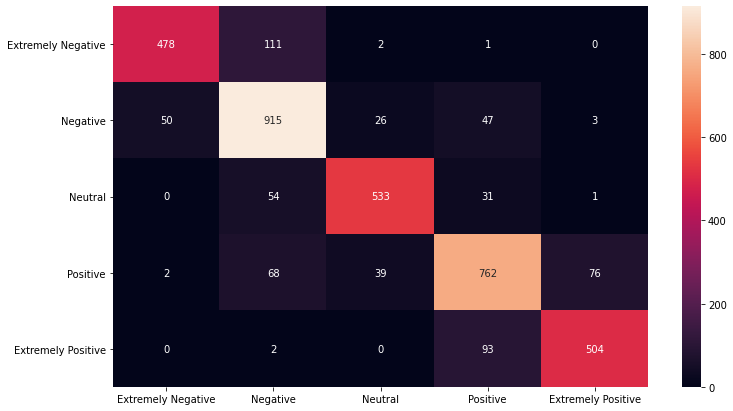

In [ ]:
conf = confusion_matrix(y_test, prediction)
labels = ['Extremely Negative','Negative', 'Neutral', 'Positive','Extremely Positive']
conf = pd.DataFrame( conf, index = [i for i in labels],columns = [i for i in labels])
plt.figure(figsize = (12,7))
sns.heatmap(conf, annot=True, fmt="d")
plt.show()

In [ ]:
print(classification_report(y_test, prediction, target_names=labels))

                    precision    recall  f1-score   support

Extremely Negative       0.90      0.81      0.85       592
          Negative       0.80      0.88      0.84      1041
           Neutral       0.89      0.86      0.87       619
          Positive       0.82      0.80      0.81       947
Extremely Positive       0.86      0.84      0.85       599

          accuracy                           0.84      3798
         macro avg       0.85      0.84      0.84      3798
      weighted avg       0.84      0.84      0.84      3798

